# Customer Behavior Analysis Project
### Internship Submission Notebook

## Objective
Analyze customer transactions to identify customer segments, purchasing patterns, and churn risks, then generate business recommendations.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

## Load Dataset

In [2]:
df = pd.read_csv("ecommerce_customer_data_custom_ratios.csv")
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


## Data Overview

In [3]:
df.info()
df.describe()

<class 'pandas.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  str    
 2   Product Category       250000 non-null  str    
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  str    
 7   Customer Age           250000 non-null  int64  
 8   Returns                202404 non-null  float64
 9   Customer Name          250000 non-null  str    
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  str    
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), str(5)
memory usage: 24.8 MB


,Customer ID,Product Price,Quantity,Total Purchase Amount,Customer Age,Returns,Age,Churn
count,250000.00000,250000.000000,250000.000000,250000.000000,250000.000000,202404.000000,250000.000000,250000.000000
mean,25004.03624,254.659512,2.998896,2725.370732,43.940528,0.497861,43.940528,0.199496
std,14428.27959,141.568577,1.414694,1442.933565,15.350246,0.499997,15.350246,0.399622
min,1.00000,10.000000,1.000000,100.000000,18.000000,0.000000,18.000000,0.000000
25%,12497.75000,132.000000,2.000000,1477.000000,31.000000,0.000000,31.000000,0.000000
50%,25018.00000,255.000000,3.000000,2724.000000,44.000000,0.000000,44.000000,0.000000
75%,37506.00000,377.000000,4.000000,3974.000000,57.000000,1.000000,57.000000,0.000000
max,50000.00000,500.000000,5.000000,5350.000000,70.000000,1.000000,70.000000,1.000000


## Data Cleaning

In [4]:
# remove duplicates
df.drop_duplicates(inplace=True)

# convert date column
df["Purchase Date"] = pd.to_datetime(df["Purchase Date"])

# check missing
df.isnull().sum()

Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47596
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64

## Feature Engineering (RFM Creation)
We calculate Recency, Frequency, and Monetary value for each customer.

In [5]:
# Monetary
monetary = df.groupby("Customer ID")["Total Purchase Amount"].sum()

# Frequency
frequency = df.groupby("Customer ID").size()

# Recency
today = df["Purchase Date"].max()
recency = df.groupby("Customer ID")["Purchase Date"].max()
recency = (today - recency).dt.days

# Combine
rfm = pd.concat([recency, frequency, monetary], axis=1)
rfm.columns = ["Recency","Frequency","Monetary"]
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
1,57,1,3491
2,298,3,7988
3,88,8,22587
4,126,4,8715
5,170,8,12524


## RFM Scoring

In [6]:
rfm["R"] = pd.qcut(rfm["Recency"],4,labels=[4,3,2,1])
rfm["F"] = pd.qcut(rfm["Frequency"].rank(method="first"),4,labels=[1,2,3,4])
rfm["M"] = pd.qcut(rfm["Monetary"],4,labels=[1,2,3,4])

rfm["Score"] = rfm[["R","F","M"]].astype(str).sum(axis=1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,Score
Customer ID,,,,,,,
1,57,1,3491,4,1,1,411
2,298,3,7988,2,1,1,211
3,88,8,22587,3,4,4,344
4,126,4,8715,3,2,1,321
5,170,8,12524,3,4,2,342


## Customer Segmentation

In [7]:
def segment(x):
    if x >= "444":
        return "VIP"
    elif x >= "333":
        return "Loyal"
    elif x >= "222":
        return "Potential"
    else:
        return "At Risk"

rfm["Segment"] = rfm["Score"].apply(segment)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,Score,Segment
Customer ID,,,,,,,,
1,57,1,3491,4,1,1,411,Loyal
2,298,3,7988,2,1,1,211,At Risk
3,88,8,22587,3,4,4,344,Loyal
4,126,4,8715,3,2,1,321,Potential
5,170,8,12524,3,4,2,342,Loyal


## Segment Distribution

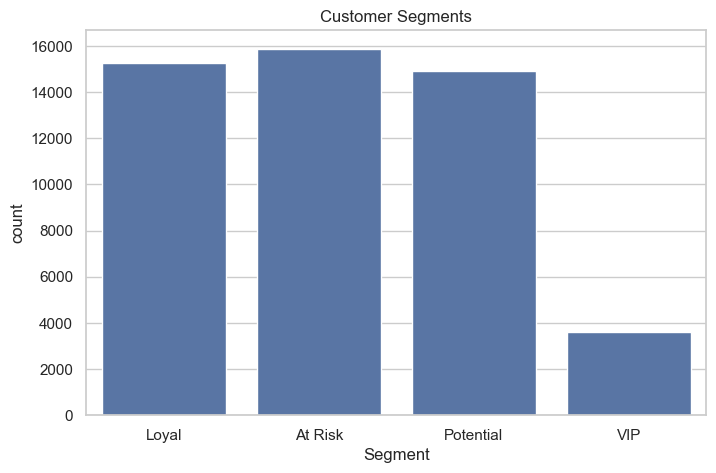

In [8]:
plt.figure(figsize=(8,5))
sns.countplot(x="Segment", data=rfm)
plt.title("Customer Segments")
plt.show()

## Product Category Popularity

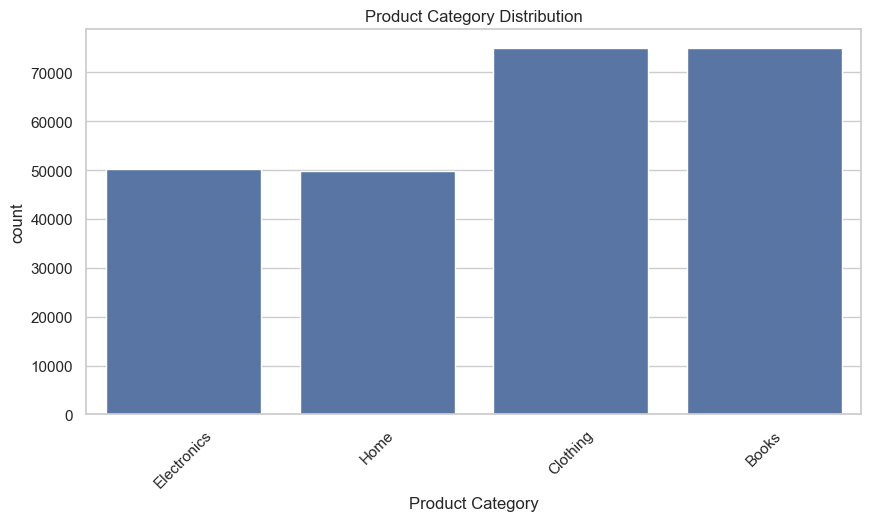

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(x="Product Category", data=df)
plt.xticks(rotation=45)
plt.title("Product Category Distribution")
plt.show()

## Payment Method Preference

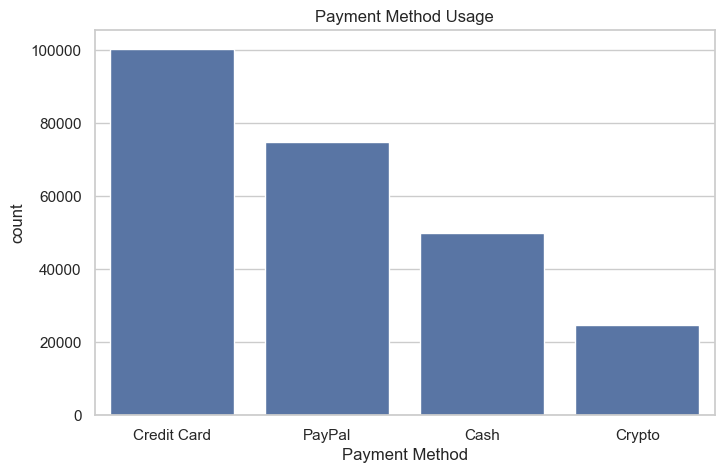

In [10]:
plt.figure(figsize=(8,5))
sns.countplot(x="Payment Method", data=df)
plt.title("Payment Method Usage")
plt.show()

## Monthly Revenue Trend

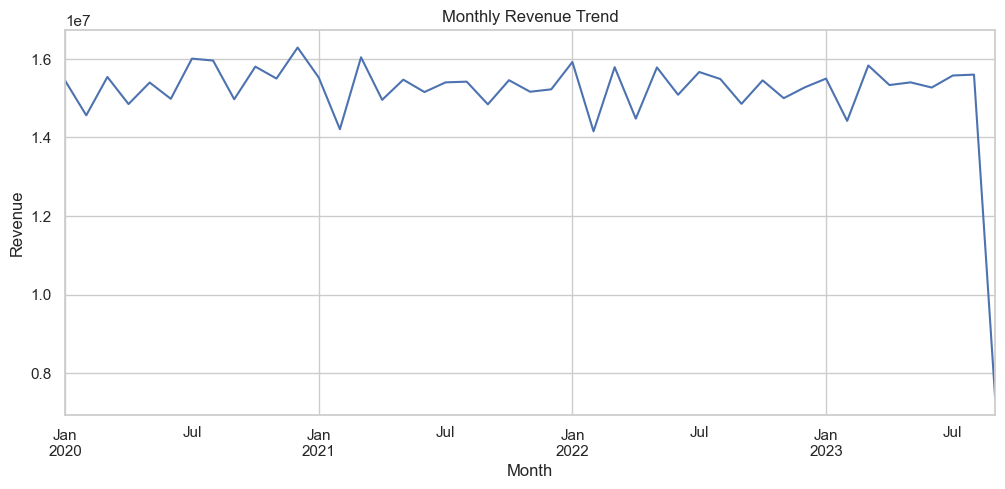

In [11]:
monthly = df.groupby(df["Purchase Date"].dt.to_period("M"))["Total Purchase Amount"].sum()

monthly.plot(figsize=(12,5))
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

## Churn Distribution

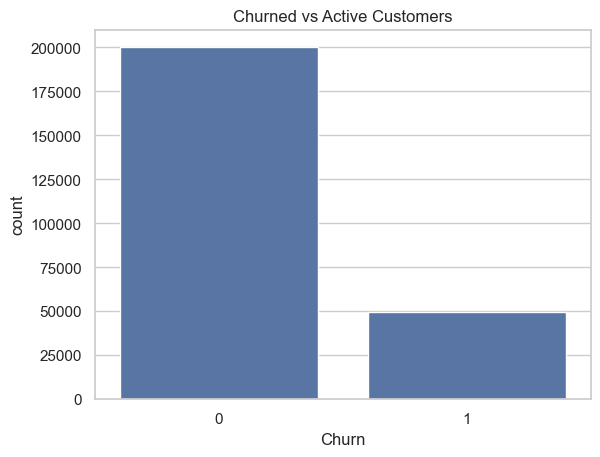

In [12]:
sns.countplot(x="Churn", data=df)
plt.title("Churned vs Active Customers")
plt.show()

## Segment Profiling

In [13]:
rfm.groupby("Segment")[["Recency","Frequency","Monetary"]].mean()

,Recency,Frequency,Monetary
Segment,,,
At Risk,537.820138,3.517244,9425.768156
Loyal,74.570333,5.765666,15628.813319
Potential,209.574571,5.072291,13749.622854
VIP,35.216321,8.440387,24370.587828


## Key Insights

- Customers with high frequency and spending form the VIP segment.
- At-risk customers have high recency (long time since purchase).
- Certain product categories dominate purchases.
- Some payment methods are clearly preferred.
- Monthly revenue trend shows seasonality or growth patterns.


## Business Recommendations for Alfido Tech

1. Provide loyalty rewards for VIP customers.
2. Send re-engagement offers to At-Risk customers.
3. Promote popular product categories.
4. Offer incentives for underused payment methods.
5. Personalize marketing campaigns using customer segments.


## Conclusion
This analysis successfully segmented customers based on purchasing behavior, identified churn risk groups, and revealed actionable insights to improve customer engagement and revenue growth.